<a href="https://colab.research.google.com/github/Zuu-Zuu/Domain-Application-of-Deep-Learning-for-Casting-Defect-Detection/blob/main/Casting_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Necessary Libraries**

In [ ]:
from google.colab import drive
import os
import zipfile

import matplotlib.pyplot as plt
import cv2
import random
import numpy as np

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torchvision.models as models

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from PIL import Image
import torch.nn.functional as F

**Mount Google Drive in Google Colab**

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


**Extract Dataset**

In [ ]:
# Define paths
zip_path = "/content/drive/MyDrive/Casting Product Image Data.zip"
extract_path = "/content/Casting_Product_Data"

# Extract dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted Dataset Folders:", os.listdir(extract_path))

Extracted Dataset Folders: ['casting_data', 'casting_512x512']


**Dataset Inspection**

In [ ]:
# Count Images Per Class
train_def_path = os.path.join(extract_path, "casting_data/casting_data/train/def_front")
train_ok_path = os.path.join(extract_path, "casting_data/casting_data/train/ok_front")
test_def_path = os.path.join(extract_path, "casting_data/casting_data/test/def_front")
test_ok_path = os.path.join(extract_path, "casting_data/casting_data/test/ok_front")

train_def_count = len(os.listdir(train_def_path))
train_ok_count = len(os.listdir(train_ok_path))
test_def_count = len(os.listdir(test_def_path))
test_ok_count = len(os.listdir(test_ok_path))

print(f"Training Set - Defective: {train_def_count}, OK: {train_ok_count}")
print(f"Test Set - Defective: {test_def_count}, OK: {test_ok_count}")

Training Set - Defective: 3758, OK: 2875
Test Set - Defective: 453, OK: 262


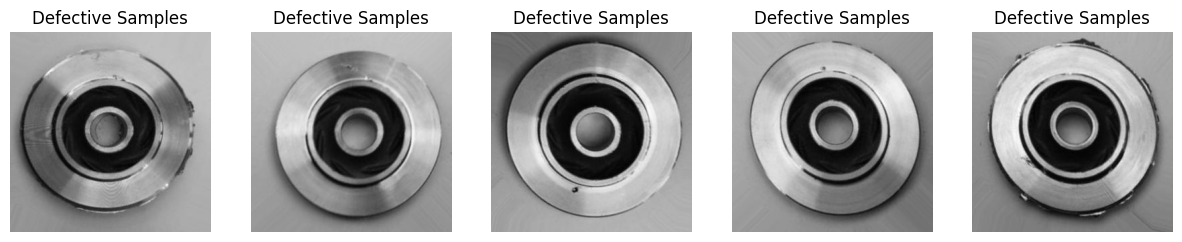

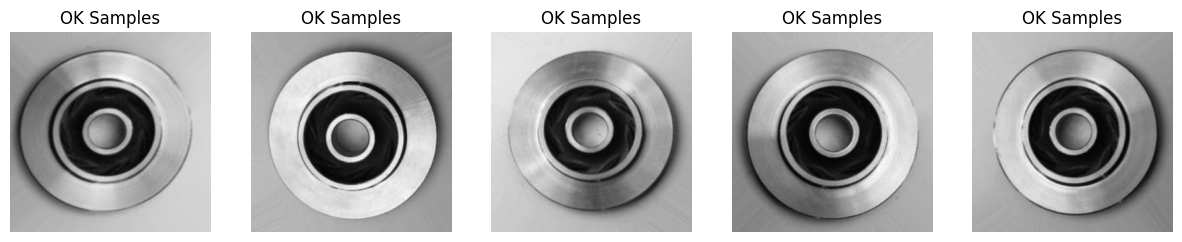

In [ ]:
# Visualizing Random Sample Images
def show_images(image_dir, title, n=5):
    images = os.listdir(image_dir)
    images = random.sample(images, min(n, len(images)))  # Get random images

    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(images):
        img_path = os.path.join(image_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(title)
    plt.show()

# Show sample images
show_images(train_def_path, "Defective Samples")
show_images(train_ok_path, "OK Samples")

In [ ]:
# Checking Image Sizes for Consistency
def check_image_sizes(image_dir):
    sizes = []
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            sizes.append(img.shape[:2])

    return np.unique(sizes, axis=0)

print("Unique image sizes in defective images:", check_image_sizes(train_def_path))
print("Unique image sizes in OK images:", check_image_sizes(train_ok_path))

Unique image sizes in defective images: [[300 300]]
Unique image sizes in OK images: [[300 300]]


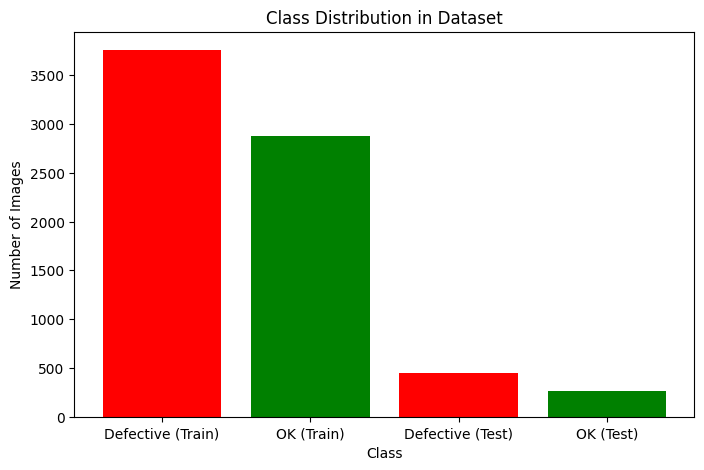

In [ ]:
# Dataset Class Distribution
labels = ["Defective (Train)", "OK (Train)", "Defective (Test)", "OK (Test)"]
counts = [train_def_count, train_ok_count, test_def_count, test_ok_count]

plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color=["red", "green", "red", "green"])
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Dataset")
plt.show()

In [ ]:
# Checking for Corrupted Images
def check_corrupted_images(image_dir):
    corrupted = []
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        img = cv2.imread(img_path)
        if img is None:
            corrupted.append(img_name)

    return corrupted

corrupted_def = check_corrupted_images(train_def_path)
corrupted_ok = check_corrupted_images(train_ok_path)

print(f"Corrupted defective images: {len(corrupted_def)}")
print(f"Corrupted OK images: {len(corrupted_ok)}")

Corrupted defective images: 0
Corrupted OK images: 0


**Data Preprocessing & Augmentation**

In [ ]:
# Define transformations for training (with augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.RandomHorizontalFlip(),  # Flip images randomly
    transforms.RandomRotation(10),  # Rotate images
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
])

# Define transformations for testing (no augmentation)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
])

**Loading Dataset Using PyTorch Dataloaders**

In [ ]:
# Define dataset directories
train_dir = "/content/Casting_Product_Data/casting_data/casting_data/train"
test_dir = "/content/Casting_Product_Data/casting_data/casting_data/test"

# Load train dataset
train_dataset = ImageFolder(root=train_dir, transform=train_transforms)

# Load test dataset
test_dataset = ImageFolder(root=test_dir, transform=test_transforms)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print dataset size
print(f"Train Dataset Size: {len(train_dataset)} images")
print(f"Test Dataset Size: {len(test_dataset)} images")

Train Dataset Size: 6633 images
Test Dataset Size: 715 images


**Displaying a Batch of Training Data**

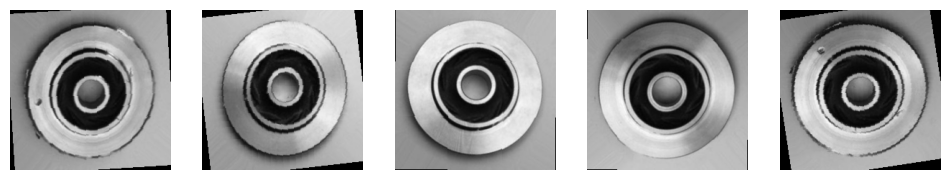

In [ ]:
# Get a batch of training data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Display images
fig, axes = plt.subplots(1, 5, figsize=(12, 4))
for i in range(5):
    img = images[i].numpy().transpose((1, 2, 0))  # Convert tensor to image
    img = img * 0.5 + 0.5  # Undo normalization
    axes[i].imshow(img, cmap="gray")
    axes[i].axis("off")
plt.show()

**Defining ResNet50 Model**

In [ ]:
# Load pre-trained ResNet50 model
resnet50 = models.resnet50(pretrained=True)

# Modify the final fully connected layer to classify 2 categories (OK vs. Defective)
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),  # Additional custom layer
    nn.ReLU(),
    nn.Dropout(0.4),  # Dropout for regularization
    nn.Linear(256, 2)  # Output layer (2 classes: OK, Defective)
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)

# Print model architecture
print(resnet50)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 174MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

**Building a Custom CNN Model**

In [ ]:
# Define Custom CNN
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        return x

**Combining ResNet50 with Custom CNN (Ensemble Model)**

In [ ]:
# Create models
custom_cnn = CustomCNN().to(device)

class EnsembleModel(nn.Module):
    def __init__(self, custom_cnn, resnet50):
        super(EnsembleModel, self).__init__()
        self.cnn = custom_cnn
        self.resnet = resnet50

    def forward(self, x):
        x = self.cnn(x)
        x = self.resnet(x)
        return x

In [ ]:
# Initialize the ensemble model
model = EnsembleModel(custom_cnn, resnet50).to(device)

In [ ]:
# Test model forward pass
sample_input = torch.randn(1, 3, 224, 224).to(device)
output = model(sample_input)
print("Model Forward Pass Successful! Output Shape:", output.shape)

Model Forward Pass Successful! Output Shape: torch.Size([1, 2])


In [ ]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

**Training Implementation**

In [ ]:
# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses, test_losses = [], []
    train_acc, test_acc = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct_train = 0.0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))
        train_acc.append(correct_train / len(train_loader.dataset))

        # Validation
        model.eval()
        running_test_loss, correct_test = 0.0, 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs, 1)
                correct_test += (predicted == labels).sum().item()
                running_test_loss += loss.item()

        test_losses.append(running_test_loss / len(test_loader))
        test_acc.append(correct_test / len(test_loader.dataset))

        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc[-1]*100:.2f}% | "
              f"Test Loss: {test_losses[-1]:.4f} | Test Acc: {test_acc[-1]*100:.2f}%")

    return train_losses, test_losses, train_acc, test_acc

In [ ]:
num_epochs = 10
train_losses, test_losses, train_acc, test_acc = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)

Epoch [1/10] | Train Loss: 0.1991 | Train Acc: 91.66% | Test Loss: 0.0764 | Test Acc: 97.20%
Epoch [2/10] | Train Loss: 0.0540 | Train Acc: 98.48% | Test Loss: 0.0273 | Test Acc: 98.88%
Epoch [3/10] | Train Loss: 0.0367 | Train Acc: 98.73% | Test Loss: 0.0157 | Test Acc: 99.30%
Epoch [4/10] | Train Loss: 0.0254 | Train Acc: 99.13% | Test Loss: 0.0265 | Test Acc: 99.16%
Epoch [5/10] | Train Loss: 0.0290 | Train Acc: 99.05% | Test Loss: 0.0103 | Test Acc: 99.44%
Epoch [6/10] | Train Loss: 0.0226 | Train Acc: 99.34% | Test Loss: 0.0137 | Test Acc: 99.44%
Epoch [7/10] | Train Loss: 0.0163 | Train Acc: 99.47% | Test Loss: 0.0086 | Test Acc: 99.86%
Epoch [8/10] | Train Loss: 0.0126 | Train Acc: 99.61% | Test Loss: 0.0182 | Test Acc: 99.30%
Epoch [9/10] | Train Loss: 0.0161 | Train Acc: 99.61% | Test Loss: 0.0151 | Test Acc: 99.44%
Epoch [10/10] | Train Loss: 0.0235 | Train Acc: 99.23% | Test Loss: 0.0212 | Test Acc: 99.72%


**Model Evaluation & Performance Analysis**

In [ ]:
model.eval()

# Store true labels and predictions
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Store results
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Finished collecting predictions.")

Finished collecting predictions.


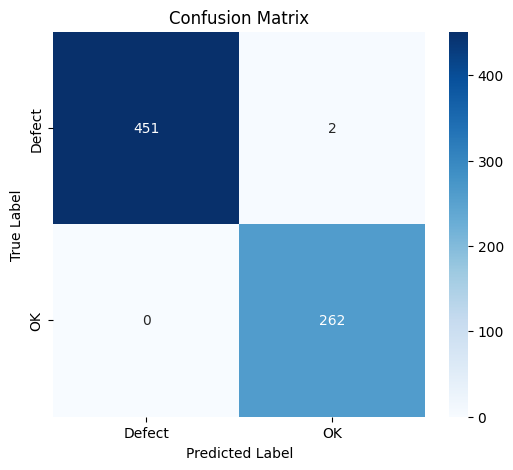

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = ["Defect", "OK"]

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Display Classification Report
print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=class_names, digits=4))

Classification Report:
               precision    recall  f1-score   support

      Defect     1.0000    0.9956    0.9978       453
          OK     0.9924    1.0000    0.9962       262

    accuracy                         0.9972       715
   macro avg     0.9962    0.9978    0.9970       715
weighted avg     0.9972    0.9972    0.9972       715



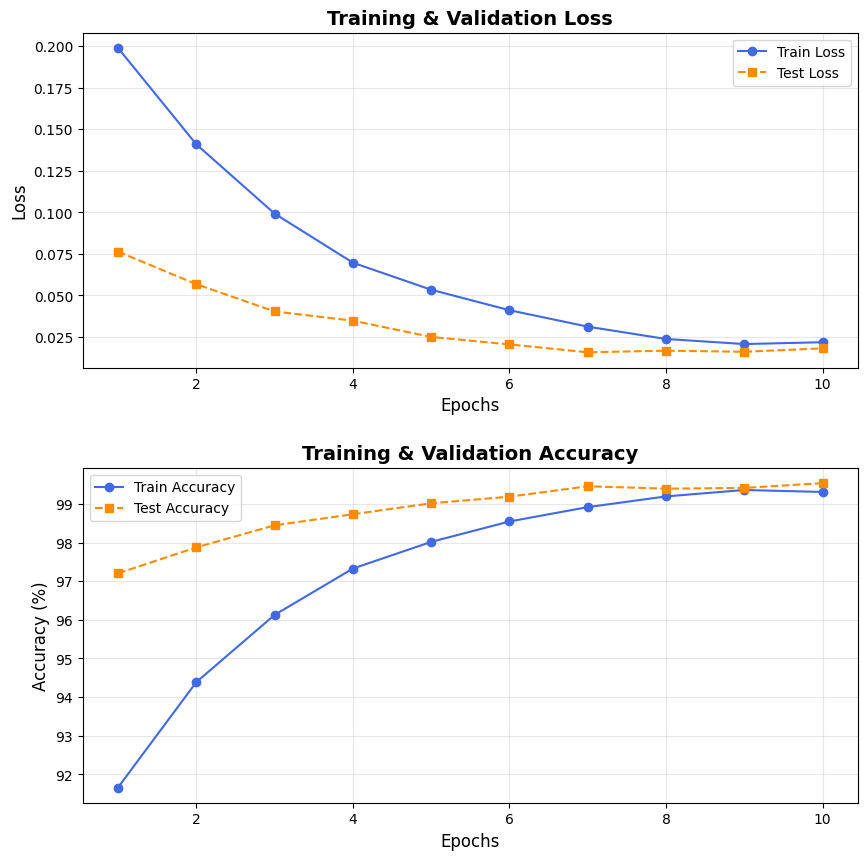

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Smooth function
def smooth_curve(points, factor=0.6):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            smoothed_points.append(smoothed_points[-1] * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Smooth the loss and accuracy values
train_losses_smooth = smooth_curve(train_losses)
test_losses_smooth = smooth_curve(test_losses)
train_acc_smooth = smooth_curve([x * 100 for x in train_acc])
test_acc_smooth = smooth_curve([x * 100 for x in test_acc])

# Plot Loss
axes[0].plot(range(1, num_epochs + 1), train_losses_smooth, label="Train Loss", color="royalblue", linestyle='-', marker="o")
axes[0].plot(range(1, num_epochs + 1), test_losses_smooth, label="Test Loss", color="darkorange", linestyle='--', marker="s")
axes[0].set_xlabel("Epochs", fontsize=12)
axes[0].set_ylabel("Loss", fontsize=12)
axes[0].set_title("Training & Validation Loss", fontsize=14, fontweight="bold")
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot Accuracy
axes[1].plot(range(1, num_epochs + 1), train_acc_smooth, label="Train Accuracy", color="royalblue", linestyle='-', marker="o")
axes[1].plot(range(1, num_epochs + 1), test_acc_smooth, label="Test Accuracy", color="darkorange", linestyle='--', marker="s")
axes[1].set_xlabel("Epochs", fontsize=12)
axes[1].set_ylabel("Accuracy (%)", fontsize=12)
axes[1].set_title("Training & Validation Accuracy", fontsize=14, fontweight="bold")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.subplots_adjust(hspace=0.3)
plt.show()

**Model Deployment & Prediction**

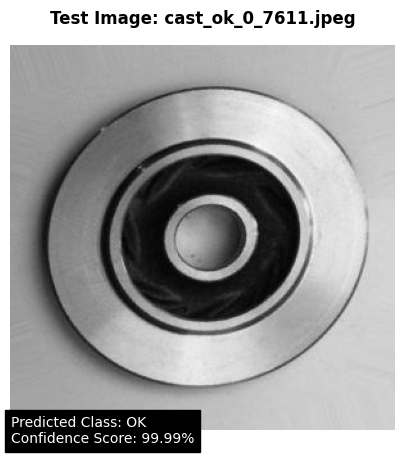

In [ ]:
def predict_and_display(image_path, model, transform, class_names):
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # Inference
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        probs = F.softmax(output, dim=1)  # Convert logits to probabilities
        confidence, predicted = torch.max(probs, 1)

    # Extract results
    predicted_class = class_names[predicted.item()]
    confidence_score = confidence.item() * 100  # Convert to percentage

    # Display image with overlay text
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(image)
    ax.set_title(f"Test Image: {image_path.split('/')[-1]}", fontsize=12, fontweight='bold', pad=15)
    ax.axis("off")

    # Add a black background text box
    text_str = f"Predicted Class: {predicted_class.upper()}\nConfidence Score: {confidence_score:.2f}%"
    ax.text(0, image.size[1] + 10, text_str, fontsize=10, color="white",
            bbox=dict(facecolor="black", edgecolor="black"))

    plt.show()

# Example usage
test_image_path = "/content/Casting_Product_Data/casting_data/casting_data/test/ok_front/cast_ok_0_7611.jpeg"
predict_and_display(test_image_path, model, test_transforms, class_names)